# this is flawed?

turns out that the conversion factor is source spectrum dependent, so is this valid? 

## for 
we assume all sources behave/look like the calspec catalogue, so fitting to that would still be in line with that principle.

## agaisnt 
errors are large ~0.1 in g, so would become the dominant error source in high extinction fields.

## solution
It isn't constant and that is accepted. Just take note of how the error evolves with colour.

In [14]:
from tools import *
%matplotlib notebook
from make_synmags import Spec_mags
from astropy.modeling.blackbody import BlackBody1D
from astropy import units as u
from extinction import odonnell94
import sys
sys.path.append('../extinction/')
from extcurve_s16 import extcurve
from copy import deepcopy

In [23]:
# Generic load in 

path = '../../data/pickle/'
files = glob(path + '*.dat')
files = [x for x in files if (('ukr' not in x) and ('ukw' not in x))]
def Specs(Specs):
    specs = []
    for spec in Specs:
        model_sed = source_synphot.source.pre_process_source(spec,np.nan,'ps1g',0,Renorm=False)
        specs += [model_sed]
    return specs
#pickle = Specs(files)

passbands = at.Table.read('source_synphot/passbands/pbzptmag.txt',format='ascii')
pbnames = [x['obsmode'] for x in passbands if x['passband'].startswith("PS1")]
pbnames += [x['obsmode'] for x in passbands if x['passband'].startswith("Kep")]
#pbnames += [x['obsmode'] for x in passbands if x['passband'].startswith("TESS/tess.")]

model_mags = 0.
model = 'AB'
pbs = source_synphot.passband.load_pbs(pbnames, model_mags, model)
pbnames = pbs.keys()



In [413]:
pbnames

odict_keys(['ps1g', 'ps1r', 'ps1i', 'ps1z', 'ps1y'])

In [3]:
models = at.Table.read('ckmodels.txt',format='ascii')
logZ = 0.
model_sed_names = []
temp = []
for s in models:
    teff = max(3500.,s['teff'])
    logg = myround(s['logg'])
    # the models with logg < 1 are just padded with 0s
    if logg >= 1:
        temp.append(teff)
        modstring = 'ckmod{:.0f}_{:.1f}_{:.2f}'.format(teff,logZ, logg)
        model_sed_names.append(modstring)
cks = source_synphot.source.load_source(model_sed_names)

In [3]:
b19 = 1
ebv = 0.884*b19
ebv = 0.996*b19
#ebv = 1
Rv = 3.1
av = ebv*Rv

wave = np.arange(100,12000) * u.AA
bb = BlackBody1D(7000*u.K)
flux = bb(wave)
bb7 = S.ArraySpectrum(wave.value,flux.value,fluxunits='fnu')
bb7.convert('flam')
#red = apply(extcurve(0)(wave.value)*b19,bb7.flux)
red = apply(fitzpatrick99(bb7.wave,a_v=av,r_v=3.1),bb7.flux)
bb7r = S.ArraySpectrum(wave.value,red,fluxunits='flam')

bb = BlackBody1D(3000*u.K)
flux = bb(wave)
bb5 = S.ArraySpectrum(wave.value,flux.value,fluxunits='fnu')
bb5.convert('flam')
red = apply(fitzpatrick99(bb5.wave,a_v=av,r_v=3.1),bb5.flux)
bb5r = S.ArraySpectrum(wave.value,red,fluxunits='flam')



In [42]:
mags7 = Spec_mags([bb7,bb7r],pbs)
mags5 = Spec_mags([bb5,bb5r],pbs)

In [43]:
np.diff(mags7['ps1g'])/(b19)

array([3.52229501])

<IPython.core.display.Javascript object>


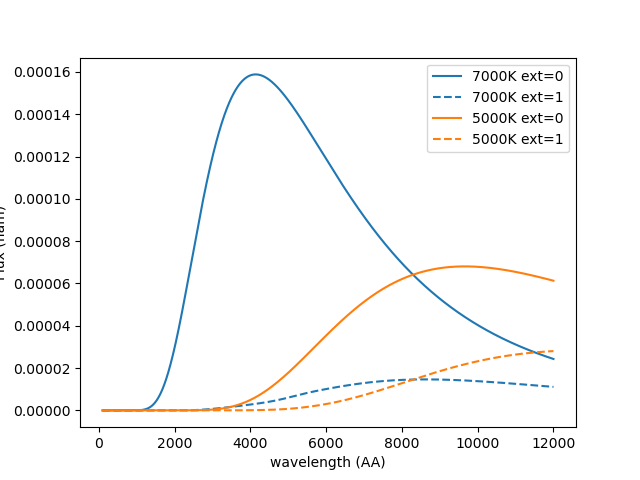

In [45]:
plt.figure()
plt.plot(bb7.wave,bb7.flux,'C0',label='7000K ext=0')
plt.plot(bb7.wave,bb7r.flux,'C0--',label='7000K ext=1')

plt.plot(bb5.wave,bb5.flux,'C1',label='5000K ext=0')
plt.plot(bb5.wave,bb5r.flux,'C1--',label='5000K ext=1')

plt.ylabel('Flux (flam)')
plt.xlabel('wavelength (AA)')
plt.legend()
plt.savefig('extinction_test.png')

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       1.71852085e-05, 1.71818838e-05, 1.71785598e-05])

In [51]:
mags

{'g': array([ 16.44883353,   9.27868118,  16.9846116 ,  14.43321248,
          7.96274814,   9.34486055,  12.24258741,   4.66558665,
         11.65574604,   8.32061133,  16.66583207,   5.68467134,
          9.44702209,  10.32644381,  10.41571096,   8.53443725,
         11.41418272,  12.87805263,   9.231374  ,   8.17450105,
         12.47222556,   1.62237003,   6.83321196,  12.66358282,
          4.13243563,   9.83615295,   4.23066234,  13.1126184 ,
         12.46827567,   4.90959597,  14.42650505,   8.94013679,
         11.82414524,  14.49437916,  12.20593608,   6.71999807,
          5.69537793,  13.66233684,   7.8066188 ,  13.68977737,
          9.58057846,  15.52311518,  14.72033445,  15.89736593,
          9.31015212,   8.86170027,  12.80728127,  10.90479643,
          9.12072095,  -0.09527742,   9.83692641,   9.77282003,
          9.37305899, -26.52972384,   6.43984256,  10.0835243 ,
         16.98284133,   6.43583555,   5.55970167,   6.92865964,
         13.95352123,  17.46364722,

In [8]:
path = '/Users/rridden/Documents/work/data/current_calspec/'
current = glob(path+'*.dat')
current = np.array(current)
files = np.array(glob(path+'*.fits'))

# select only the stis models, since those are the most well callibrated sources
ind = []
for i in range(len(current)):
    if ('stis' in current[i]) & ('ngc6681' not in current[i]):
        ind += [i]
ind = np.array(ind)
current = current[ind]

cur = Specs(current)
cur_all = deepcopy(cur)
mags = Spec_mags(cur,pbs,0)
gr = mags['g'] - mags['r']

good = (gr > 0.2) & (gr < 0.7)
cur = Specs(current[good])

Warning, 5 of 3667 bins contained negative fluxes; they have been set to zero.
Warning, 40 of 3660 bins contained negative fluxes; they have been set to zero.
Warning, 5 of 6262 bins contained negative fluxes; they have been set to zero.
Warning, 91 of 6558 bins contained negative fluxes; they have been set to zero.
Warning, 28 of 6262 bins contained negative fluxes; they have been set to zero.
Warning, 3 of 4861 bins contained negative fluxes; they have been set to zero.
Warning, 27 of 6262 bins contained negative fluxes; they have been set to zero.
Warning, 64 of 6262 bins contained negative fluxes; they have been set to zero.
Warning, 25 of 248786 bins contained negative fluxes; they have been set to zero.
Warning, 10 of 6254 bins contained negative fluxes; they have been set to zero.
Warning, 5 of 3889 bins contained negative fluxes; they have been set to zero.
Warning, 17 of 6234 bins contained negative fluxes; they have been set to zero.
Warning, 82 of 6560 bins contained negativ

In [5]:
b19 = 1
ebv = 0.884*b19
Rv = 3.1
av = ebv*Rv

In [86]:
model_0 = Spec_mags(cur,pbs,av = 0,Rv=Rv)
model_1 = Spec_mags(cur,pbs,av = av,Rv=Rv)


In [47]:
val = {'ps1g':3.518,'r':2.617,'i':1.971,'z':1.549}
f = 'ps1g'
magdiff = model_1[f] - model_0[f]
np.nanmedian(magdiff/(0.884*b19))

3.6120051155421127

In [41]:
val[f] - np.nanmedian(magdiff)

0.35060341632271186

In [44]:
np.nanmedian(magdiff/0.884)

3.583027809589692

In [13]:
np.nanmedian(magdiff)

1.2773003638397338

In [45]:
np.nanmedian(magdiff)

2.4312625091786355

In [38]:
from tabulate import tabulate
print(tabulate([['Rg', -0.0954], ['Rr', 0.001], ['Ri', 0.0234], ['Rz', 0.0106]], headers=['Vector', 'Difference'], tablefmt='orgtbl'))

| Vector   |   Difference |
|----------+--------------|
| Rg       |      -0.0954 |
| Rr       |       0.001  |
| Ri       |       0.0234 |
| Rz       |       0.0106 |


In [41]:
val[f]-magdiff

array([-0.20000576, -0.19325463, -0.12463613, -0.15114322,  0.00796567,
       -0.03402787,  0.00583602, -0.01549234, -0.13423936, -0.08468466,
       -0.15614856, -0.19058249,  0.06340593, -0.14268809, -0.05958707,
       -0.15612146, -0.10684506, -0.18618507, -0.12284672, -0.09370638,
       -0.15962108, -0.08308317, -0.19590233, -0.18957779, -0.2075552 ,
        0.02095876,  0.00373838, -0.19832935, -0.08994332, -0.00744173,
       -0.06087263, -0.18347033, -0.02392251,  0.03361463, -0.10206999,
       -0.1075977 , -0.16597224, -0.15150653, -0.05954933,  0.00226648,
       -0.09714002, -0.08114509, -0.0519242 , -0.0919919 ,  0.01032542,
       -0.19250608, -0.0825476 ,  0.00447999, -0.03194813, -0.00454049,
       -0.11699037, -0.2179678 , -0.19905059, -0.17466174, -0.17275043,
       -0.17040139, -0.01029416, -0.19367075, -0.15450244, -0.19140363,
       -0.00614958, -0.07570758, -0.10092004, -0.17379537,  0.00037623,
        0.00520737, -0.07021097, -0.19295854,  0.01878204, -0.11

In [4]:
def Spec_mags(Models,pbs,ex=0,Conversion = 0.96270205,mod='od94'):
    """
    Generate synthetic magnitudes from the models and passbands added.
    Conversion converts between Ebv and Egr, the Green value is 0.981, but the best fit value
    was found to be 1.029.
    """
    #print('lego')
    a_v = 3.1*(ex ) # ex = extinction from Bayestar19 = Egr
    pbg, zpg = pbs['ps1g']
    pbr, zpr = pbs['ps1r']
    pbi, zpi = pbs['ps1i']
    pbz, zpz = pbs['ps1z']
    pby, zpy = pbs['ps1y']
    pbk, zpk = pbs['Kep']
    #pbt, zpt = pbs['tess']

    mg = []
    mr = []
    mi = []
    mz = []
    my = []
    mk = []
    mt = []
    # construct mags
    ind = []
    red = {}
    for model in Models:
        #model = Models[modelname]
        if a_v > 0:
            if mod == 'od94':
                model = S.ArraySpectrum(model.wave, 
                                        apply(odonnell94(model.wave.astype('double'),a_v,3.1),model.flux))
            elif mod == 'f99':
                model = S.ArraySpectrum(model.wave, 
                                        apply(fitzpatrick99(model.wave.astype('double'),a_v,3.1),model.flux))
        mg += [source_synphot.passband.synphot(model, pbg,zpg)]
        mr += [source_synphot.passband.synphot(model, pbr,zpr)]
        mi += [source_synphot.passband.synphot(model, pbi,zpi)]
        mz += [source_synphot.passband.synphot(model, pbz,zpz)]
        my += [source_synphot.passband.synphot(model, pby,zpy)]
        mk += [source_synphot.passband.synphot(model, pbk,zpk)]
        #mt += [source_synphot.passband.synphot(model, pbt,zpt)]

    mg = np.array(mg)
    mr = np.array(mr)
    mi = np.array(mi)
    mz = np.array(mz)
    my = np.array(my)
    mk = np.array(mk)
    #mt = np.array(mt)
    good = (np.isfinite(mg) & np.isfinite(mr) & np.isfinite(mi) & np.isfinite(mz) 
            & np.isfinite(my) & np.isfinite(mk)) #& np.isfinite(mt))
    d = {'g':mg[good], 'r':mr[good],'i':mi[good],'z':mz[good], 'y':my[good],'kep':mk[good]}#,'tess':mt[good]}
    return d

In [5]:
def fit_conversion(Conversion,model,pbs,mod,b19=1):
    #print(Conversion)
    model_0 = Spec_mags(model,pbs,0,Conversion,mod=mod)
    model_1 = Spec_mags(model,pbs,b19,Conversion,mod=mod)
    val = {'g':3.518,'r':2.617,'i':1.971,'z':1.549}
    dif = []
    for name in val:
        magdiff = (model_1[name] - model_0[name])/b19
        dif += [(val[name] - np.nanmedian(magdiff))**2/val[name]]
    dif = np.array(dif)
    #print(np.nansum(abs(dif)))
    return np.nansum(abs(dif))

In [9]:
ref_ind = np.where('/Users/rridden/Documents/work/data/current_calspec/hd074000_stis_005.dat' == current[good])[0][0]

In [7]:
odres = minimize(fit_conversion,0.981,args=([cur[ref_ind]],pbs,'od94'),method='Nelder-Mead')
fres = minimize(fit_conversion,0.981,args=([cur[ref_ind]],pbs,'f99'),method='Nelder-Mead')

In [8]:
b19 = np.arange(.1,2,.1)
f = []
for b in b19:
    f += [minimize(fit_conversion,0.981,args=([cur[ref_ind]],pbs,'f99',b),method='Nelder-Mead').x[0]]

<IPython.core.display.Javascript object>


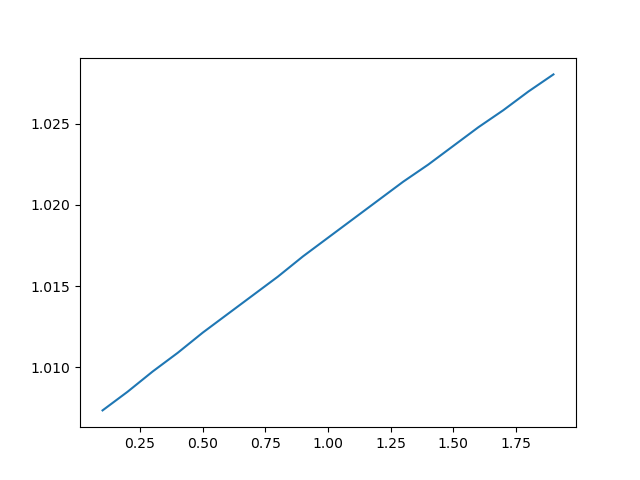

In [9]:
plt.figure()
plt.plot(b19,f)

In [10]:
model_0 = Spec_mags([cur[ref_ind]],pbs,0,0,mod='f99')
model_1 = Spec_mags([cur[ref_ind]],pbs,1,0,mod='f99')

In [11]:
def mag2flux(mag,zp=25):
    flux = 10**(-1/2.5*(mag-zp))
    return flux
    

def r_comp(c,mag,ext=0,R_var=False):
    zp = 25
    gr = ext*(mag['g'] - mag['r'])
    if R_var:
        ge = ext * R_val('g',gr=gr,ext=ext)[0]
        re = ext * R_val('r',gr=gr,ext=ext)[0]
        ie = ext * R_val('i',gr=gr,ext=ext)[0]
        ze = ext * R_val('z',gr=gr,ext=ext)[0]
    else:
        ge = ext * 3.629# 3.518 #
        re = ext * 2.611# 2.617 #
        ie = ext * 1.935# 1.971 #
        ze = ext * 1.523# 1.549 #
    g = mag2flux(mag['g']-ge,zp)
    i = mag2flux(mag['i']-ie,zp)
    z = mag2flux(mag['z']-ze,zp)
    fit = (c[0]*g + c[1]*i + c[2]*z)*(g/i)**c[3]
    r = -2.5*np.log10(fit) + 25 + re
    return r

In [25]:
x = [0.05219065, 0.99862204, 0, 0.31264066]
r0 = r_comp(x,model_0)
r1 = r_comp(x,model_1)
r1o = r_comp(x,model_1,ext=1)

In [27]:
r1o - r0

array([2.59828262])

In [24]:
r1 - r0

array([2.48589357])

In [38]:
odzero = Spec_mags(cur_all,pbs,0,Conversion=odres.x,mod='od94')
odone = Spec_mags(cur_all,pbs,1,Conversion=odres.x,mod='od94')
fzero = Spec_mags(cur_all,pbs,0,Conversion=1,mod='f99')
fone = Spec_mags(cur_all,pbs,1,Conversion=1,mod='f99')

In [30]:
redgr = fone['g'] - fone['r']
gr = fzero['g'] - fzero['r']

<IPython.core.display.Javascript object>


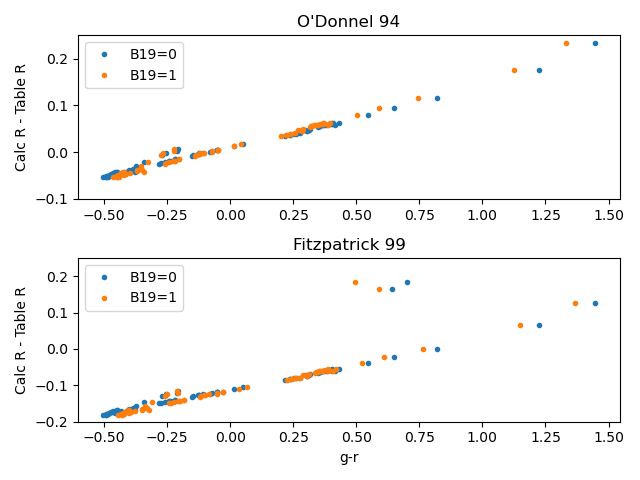

In [164]:
b='g'
plt.figure()
plt.subplot(211)
plt.title("O'Donnel 94")
redgr = odone['g'] - odone['r']
gr = odzero['g'] - odzero['r']
plt.plot(gr,(odzero[b]-odone[b])+3.518,'.',label='B19=0')
plt.plot(redgr-(3.518-2.617),(odzero[b]-odone[b])+3.518,'.',label='B19=1')
plt.legend()
#plt.xlabel('g-r')
plt.ylabel('Calc R - Table R')
plt.ylim(-.1,.25)

plt.subplot(212)
plt.title("Fitzpatrick 99")
redgr = fone['g'] - fone['r']
gr = fzero['g'] - fzero['r']
plt.plot(gr,(fzero[b]-fone[b])+3.518,'.',label='B19=0')
plt.plot(redgr-(3.518-2.617)-.1,(fzero[b]-fone[b])+3.518,'.',label='B19=1')
plt.legend()
plt.ylabel('Calc R - Table R')
plt.xlabel('g-r')
plt.ylim(-.2,.25)
plt.tight_layout()

In [175]:
rg/3.518

0.9901907115519873

<IPython.core.display.Javascript object>


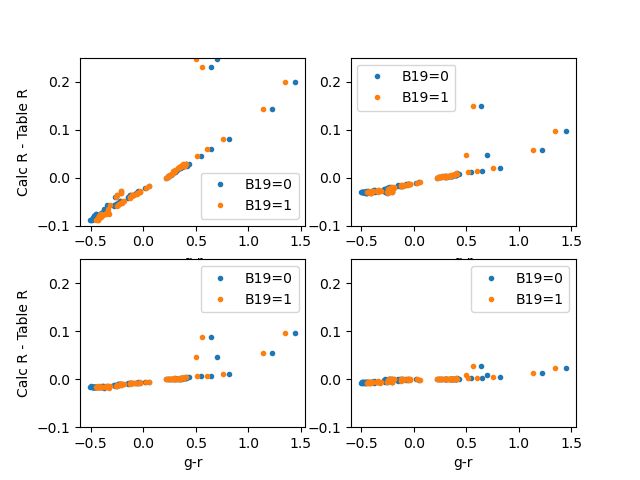

(-0.1, 0.25)

In [182]:
rg =  odone['g'][good][ref_ind] - odzero['g'][good][ref_ind]
rr =  odone['r'][good][ref_ind] - odzero['r'][good][ref_ind]
ri =  odone['i'][good][ref_ind] - odzero['i'][good][ref_ind]
rz =  odone['z'][good][ref_ind] - odzero['z'][good][ref_ind]

#rg = 3.518
#rr = 2.617
#ri = 1.971
#rz = 1.549

redgr = odone['g'] - odone['r']
gr = odzero['g'] - odzero['r']
plt.figure()
plt.subplot(221)
b='g'
plt.plot(gr,(odzero[b]-odone[b])+rg,'.',label='B19=0')
plt.plot(redgr-(rg-rr),(odzero[b]-odone[b])+rg,'.',label='B19=1')
plt.legend()
plt.ylabel('Calc R - Table R')
plt.xlabel('g-r')
plt.ylim(-.1,.25)

plt.subplot(222)
b='r'
plt.plot(gr,(odzero[b]-odone[b])+rr,'.',label='B19=0')
plt.plot(redgr-(rg-rr),(odzero[b]-odone[b])+rr,'.',label='B19=1')
plt.legend()
plt.xlabel('g-r')
plt.ylim(-.1,.25)

plt.subplot(223)
b='i'
plt.plot(gr,(odzero[b]-odone[b])+ri,'.',label='B19=0')
plt.plot(redgr-(rg-rr),(odzero[b]-odone[b])+ri,'.',label='B19=1')
plt.legend()
plt.ylabel('Calc R - Table R')
plt.xlabel('g-r')
plt.ylim(-.1,.25)

plt.subplot(224)
b='z'
plt.plot(gr,(odzero[b]-odone[b])+rz,'.',label='B19=0')
plt.plot(redgr-(rg-rr),(odzero[b]-odone[b])+rz,'.',label='B19=1')
plt.legend()
plt.xlabel('g-r')
plt.ylim(-.1,.25)

<IPython.core.display.Javascript object>


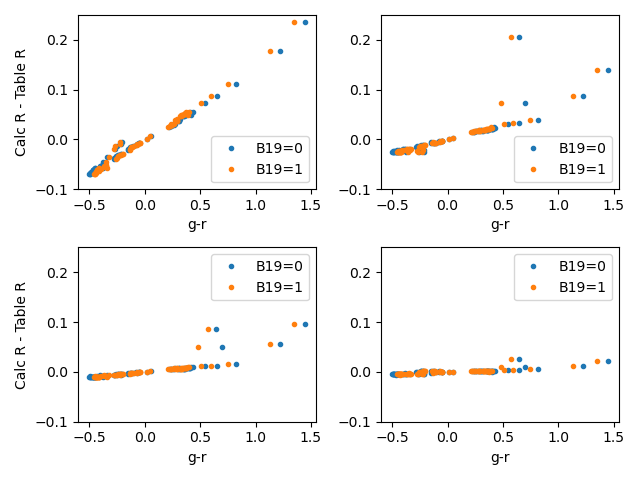

In [407]:
rg =  fone['g'][good][ref_ind] - fzero['g'][good][ref_ind]
rr =  fone['r'][good][ref_ind] - fzero['r'][good][ref_ind]
ri =  fone['i'][good][ref_ind] - fzero['i'][good][ref_ind]
rz =  fone['z'][good][ref_ind] - fzero['z'][good][ref_ind]

rg = r['g']['coeff'][1]
rr = r['r']['coeff'][1]
ri = r['i']['coeff'][1]
rz = r['z']['coeff'][1]


redgr = fone['g'] - fone['r']
gr = fzero['g'] - fzero['r']
plt.figure()
plt.subplot(221)
b='g'
plt.plot(gr,(fzero[b]-fone[b])+rg,'.',label='B19=0')
plt.plot(redgr-(rg-rr),(fzero[b]-fone[b])+rg,'.',label='B19=1')
plt.legend()
plt.ylabel('Calc R - Table R')
plt.xlabel('g-r')
plt.ylim(-.1,.25)

plt.subplot(222)
b='r'
plt.plot(gr,(fzero[b]-fone[b])+rr,'.',label='B19=0')
plt.plot(redgr-(rg-rr),(fzero[b]-fone[b])+rr,'.',label='B19=1')
plt.legend()
plt.xlabel('g-r')
plt.ylim(-.1,.25)

plt.subplot(223)
b='i'
plt.plot(gr,(fzero[b]-fone[b])+ri,'.',label='B19=0')
plt.plot(redgr-(rg-rr),(fzero[b]-fone[b])+ri,'.',label='B19=1')
plt.legend()
plt.ylabel('Calc R - Table R')
plt.xlabel('g-r')
plt.ylim(-.1,.25)

plt.subplot(224)
b='z'
plt.plot(gr,(fzero[b]-fone[b])+rz,'.',label='B19=0')
plt.plot(redgr-(rg-rr),(fzero[b]-fone[b])+rz,'.',label='B19=1')
plt.legend()
plt.xlabel('g-r')
plt.ylim(-.1,.25)
plt.tight_layout()

## looks like O'Donnel 94 is the most consistent with the bayestar19 coeffs 

In [3]:
from astropy.stats import sigma_clip
from scipy.optimize import curve_fit
from scipy.optimize import minimize

In [12]:
def line(x, c1, c2): 
    return c1 + c2*x #+ c3*x**2

def func(vals,x,y):
    fit = line(x,vals[0],vals[1])
    return np.nansum(abs(fit-y))

def calculate_R(m_int,m_e):
    gr = m_int['ps1g']-m_int['ps1i']
    ind = (gr < 1) #& (gr > -.2)
    x = deepcopy(gr)
    x = x[ind]
    
    R = {}
    bands = list(m_int.keys())
    for b in bands:
        y = deepcopy((m_e[b]-m_int[b]))/.1
        y = y[ind]
        vals = minimize(func, [0,0], args=(x, y)).x
        fit = line(x, vals[0], vals[1])
        clip = ~sigma_clip(y-fit,3,maxiters=10).mask
        #vals, pcov = curve_fit(line, x[clip], y[clip])
        vals = minimize(func, [0,0,0], args=(x, y)).x
        fit = line(x, vals[0], vals[1])
        clip = ~sigma_clip(y-fit,3,maxiters=10).mask
        std = np.nanstd(y[clip]-fit[clip])
        R[b] = {'coeff':vals,'std':std}
        
        plt.figure()
        plt.plot(x[clip],y[clip],'.')
        plt.plot(x,fit,'.')
        plt.ylabel('$m_{ext}-m_{int}$')
        plt.xlabel('$(g-r)_{int}$')
        plt.tight_layout()
        s = r'$R_{%(band)s}=%(v1)s %(v2)s(g-i)_{int}$' % {'band':b,'v1':str(np.round(vals[0],3))
                                                                              ,'v2':str(np.round(vals[1],3))}
        plt.text(.5,.8,s,transform=plt.gca().transAxes)
        plt.savefig('R_figs/'+b+'.pdf')
    return R
        
        
    

<IPython.core.display.Javascript object>


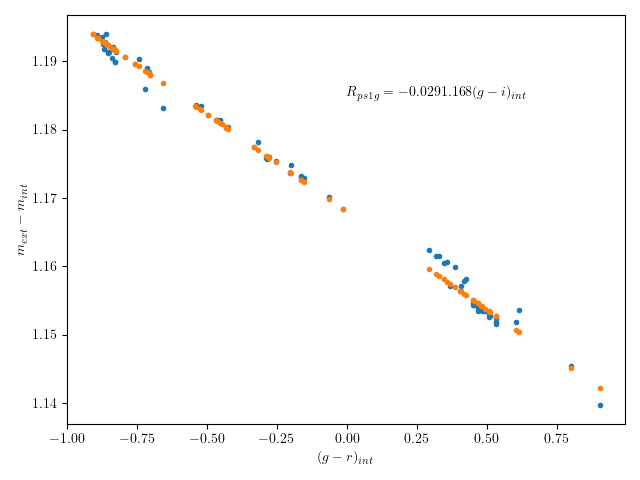

<IPython.core.display.Javascript object>


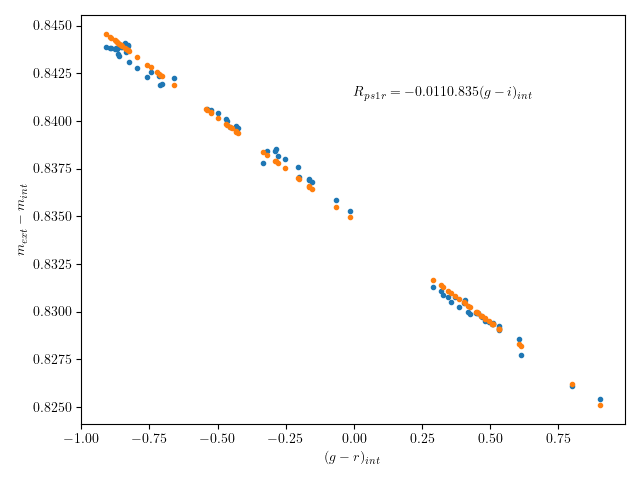

<IPython.core.display.Javascript object>


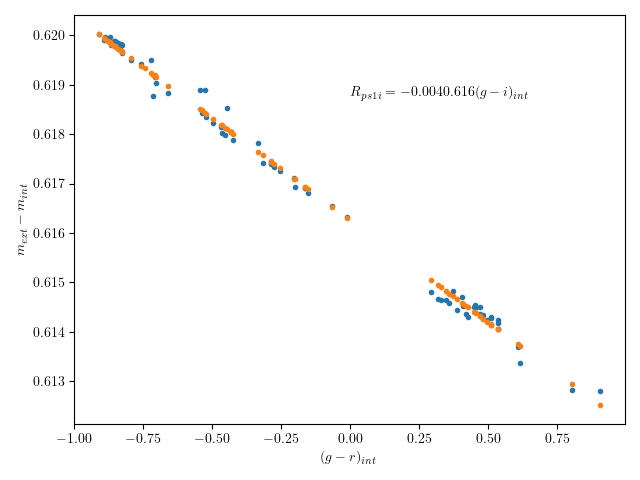

<IPython.core.display.Javascript object>


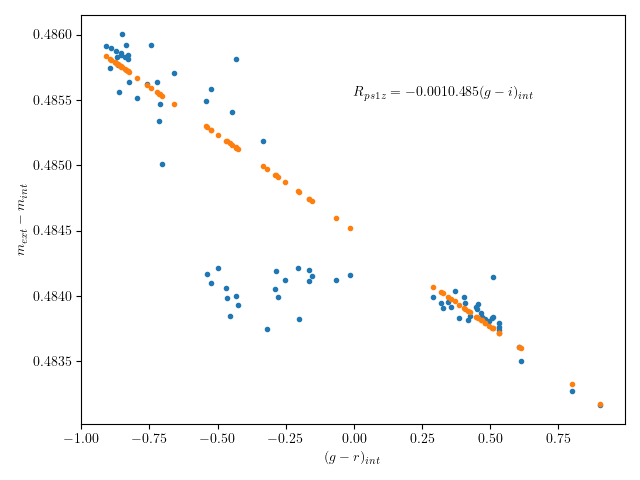

<IPython.core.display.Javascript object>


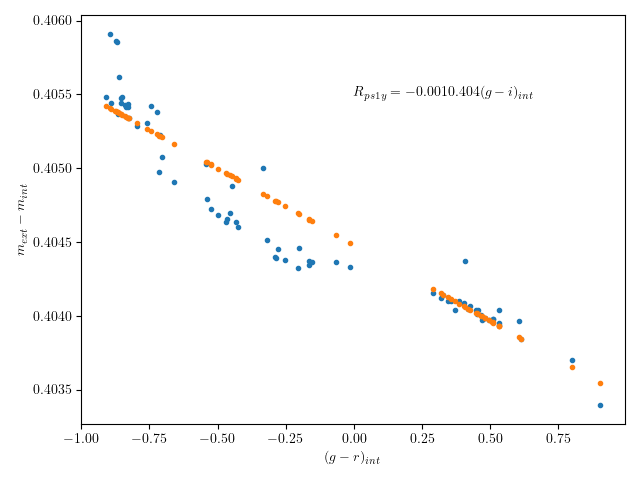

<IPython.core.display.Javascript object>


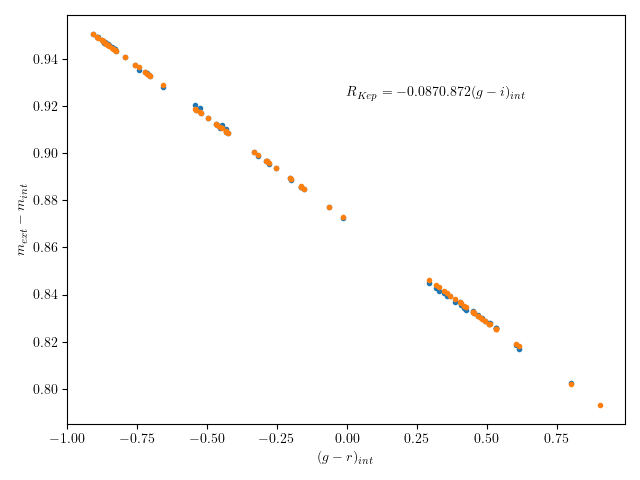

In [24]:
fzero = Spec_mags(cur_all,pbs,0)
fone = Spec_mags(cur_all,pbs,.1)
r = calculate_R(fzero,fone)

In [16]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

<IPython.core.display.Javascript object>


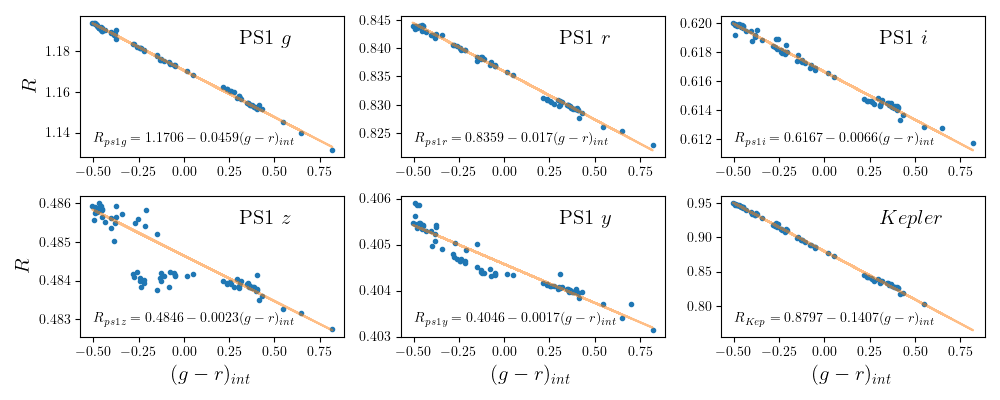

In [34]:
m_int = fzero
m_e = fone
gr = m_int['ps1g']-m_int['ps1r']
ind = (gr < 1) #& (gr > -.2)
x = deepcopy(gr)
x = x[ind]
bb = ['PS1 $g$','PS1 $r$','PS1 $i$','PS1 $z$','PS1 $y$','$Kepler$']
R = {}
bands = list(m_int.keys())
plt.figure(figsize=(10,4))

i = 1
for b in bands:
    y = deepcopy((m_e[b]-m_int[b]))/.1
    y = y[ind]
    vals = minimize(func, [0,0,0], args=(x, y)).x
    fit = line(x, vals[0], vals[1])
    fit = line(x, vals[0], vals[1])
    clip = ~sigma_clip(y-fit,3,maxiters=10).mask
    #vals, pcov = curve_fit(line, x[clip], y[clip])
    vals = minimize(func, [0,0,0], args=(x, y)).x
    fit = line(x, vals[0], vals[1])
    clip = ~sigma_clip(y-fit,3,maxiters=10).mask
    std = np.nanstd(y[clip]-fit[clip])
    R[b] = {'coeff':vals,'std':std}

    plt.subplot(2,3,i)
    plt.plot(x[clip],y[clip],'.')
    plt.plot(x,fit,alpha=.5)
    if i > 3:
        plt.xlabel('$(g-r)_{int}$',fontsize=15)
    if (i == 1) | (i == 4):
        #plt.ylabel('$m_{ext}-m_{int}$',fontsize=15)
        plt.ylabel('$R$',fontsize=15)
    
    s = r'$R_{%(band)s}=%(v2)s %(v1)s(g-r)_{int}$' % {'band':b,'v1':str(np.round(vals[0],4)),'v2':str(np.round(vals[1],4))}
    plt.text(.05,.1,s,transform=plt.gca().transAxes,fontsize=10)
    #plt.title(s,fontsize=12)
    plt.text(.6,.8,bb[i-1],transform=plt.gca().transAxes,fontsize=15)
    i+=1

plt.tight_layout()    
plt.savefig('R_figs/R_all_fits.pdf')

/Users/rridden/Documents/work/data/current_calspec/hz43b_stis_005.dat 0


<IPython.core.display.Javascript object>


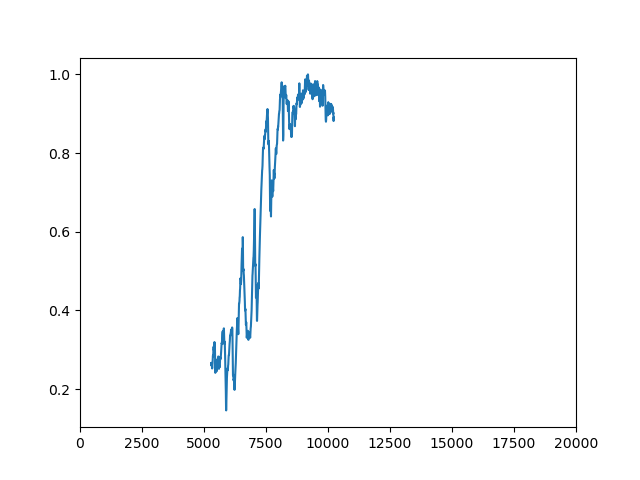

/Users/rridden/Documents/work/data/current_calspec/hd38949_stis_005.dat 1


<IPython.core.display.Javascript object>


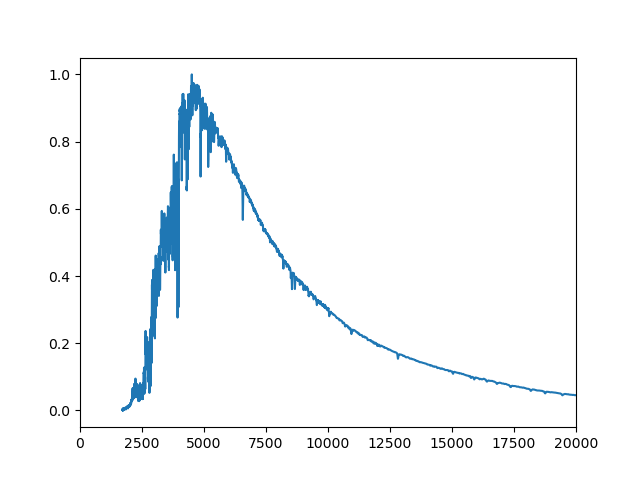

/Users/rridden/Documents/work/data/current_calspec/bd21d0607_stis_005.dat 2


<IPython.core.display.Javascript object>


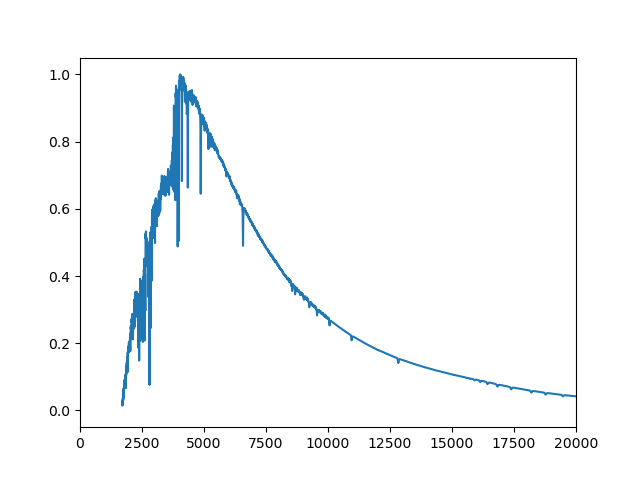

/Users/rridden/Documents/work/data/current_calspec/hd185975_stis_005.dat 3


<IPython.core.display.Javascript object>


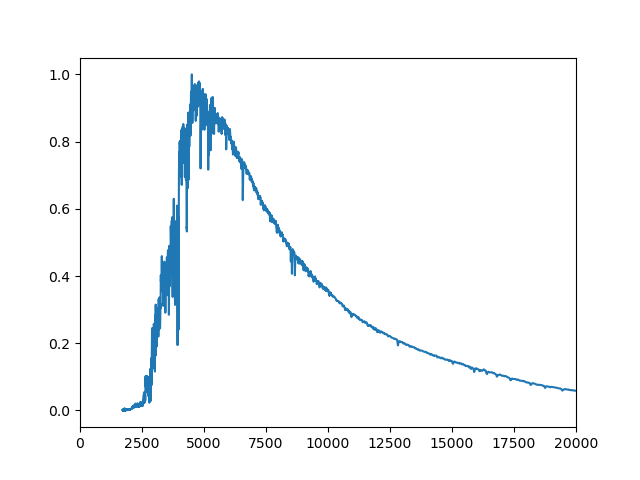

/Users/rridden/Documents/work/data/current_calspec/c26202_stiswfcnic_002.dat 4


<IPython.core.display.Javascript object>


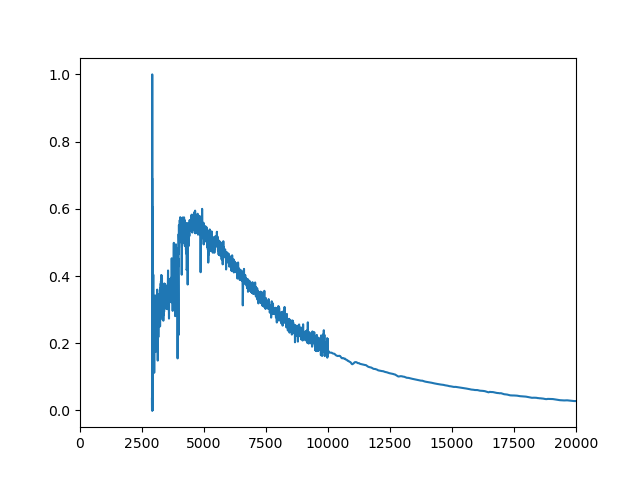

/Users/rridden/Documents/work/data/current_calspec/18sco_stis_002.dat 5


<IPython.core.display.Javascript object>


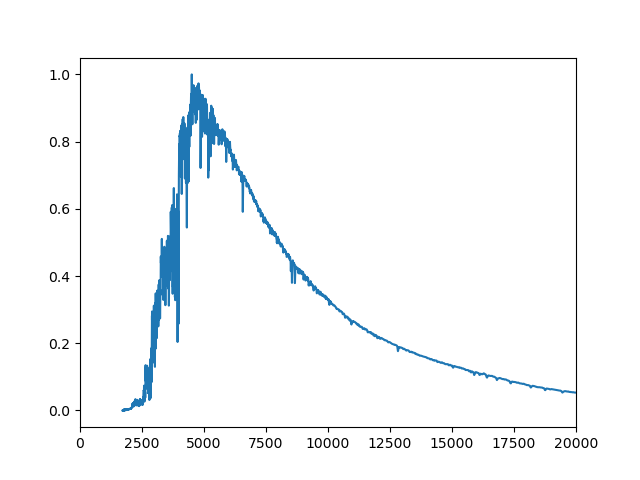

/Users/rridden/Documents/work/data/current_calspec/hd115169_stis_002.dat 6


<IPython.core.display.Javascript object>


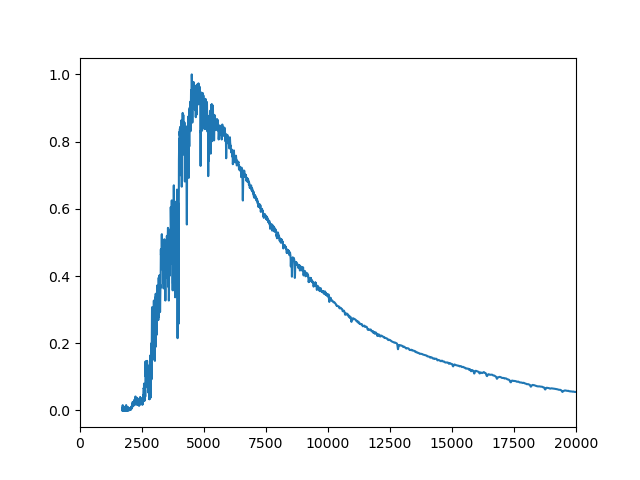

/Users/rridden/Documents/work/data/current_calspec/g191b2b_stisfuse_001.dat 7


<IPython.core.display.Javascript object>


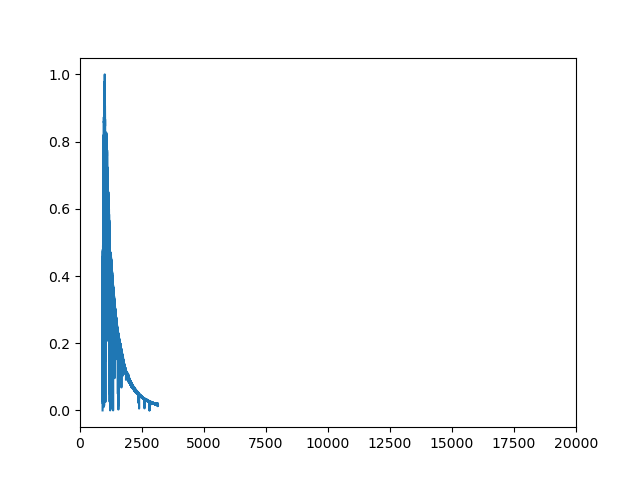

/Users/rridden/Documents/work/data/current_calspec/bd29d2091_stis_005.dat 8


<IPython.core.display.Javascript object>


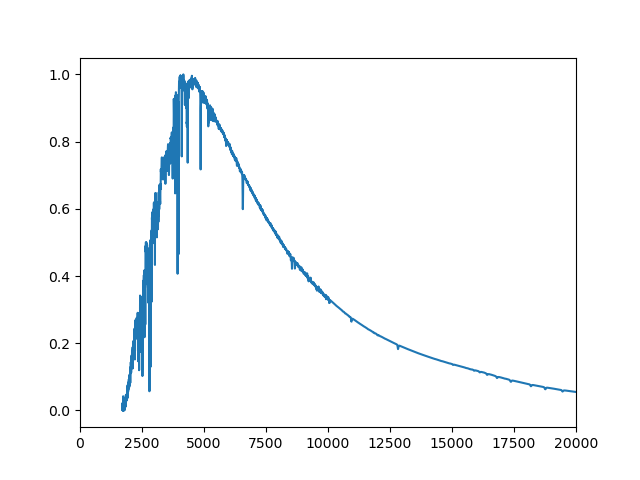

/Users/rridden/Documents/work/data/current_calspec/hd111980_stis_005.dat 9


<IPython.core.display.Javascript object>


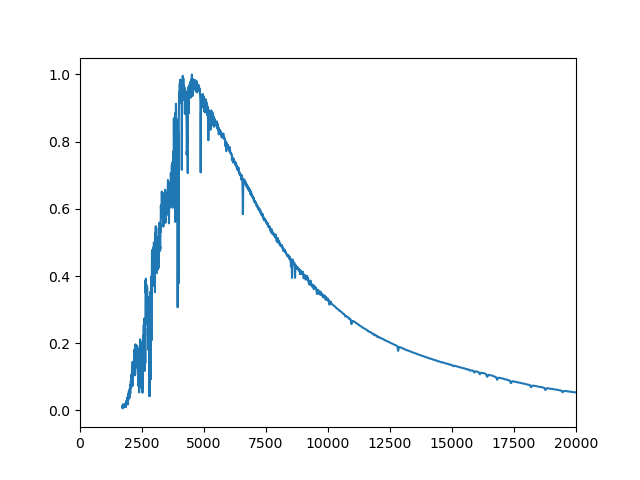

/Users/rridden/Documents/work/data/current_calspec/hd009051_stis_005.dat 10


<IPython.core.display.Javascript object>


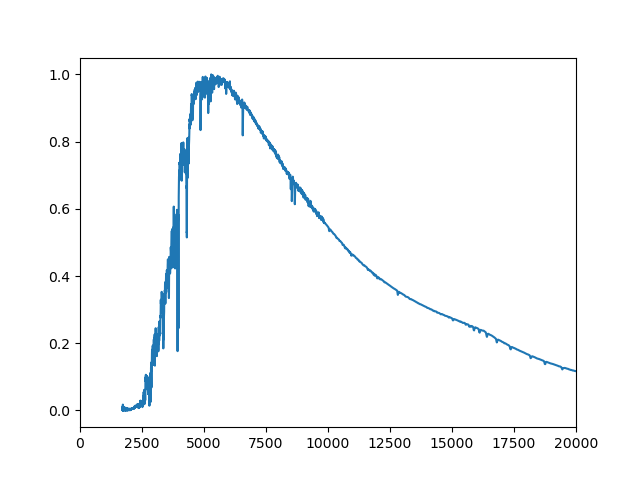

/Users/rridden/Documents/work/data/current_calspec/bd54d1216_stis_005.dat 11


<IPython.core.display.Javascript object>


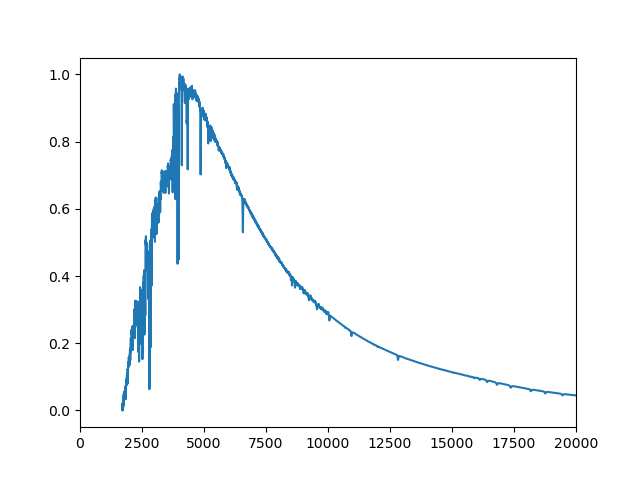

/Users/rridden/Documents/work/data/current_calspec/hd142331_stis_002.dat 12


<IPython.core.display.Javascript object>


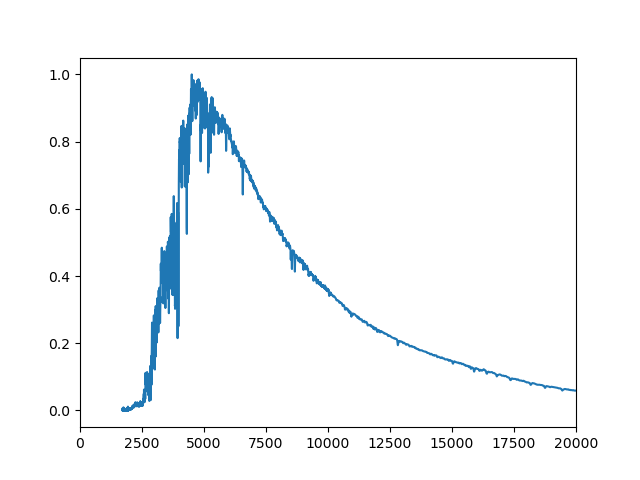

/Users/rridden/Documents/work/data/current_calspec/p041c_stisnic_008.dat 13


<IPython.core.display.Javascript object>


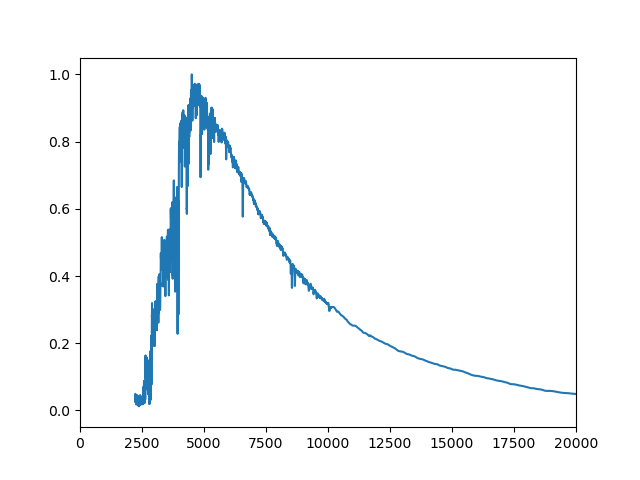

/Users/rridden/Documents/work/data/current_calspec/hd159222_stis_005.dat 14


<IPython.core.display.Javascript object>


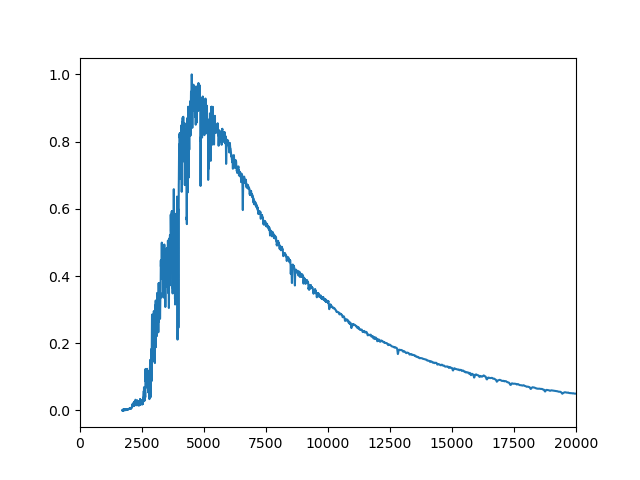

/Users/rridden/Documents/work/data/current_calspec/kf08t3_stisnic_002.dat 15


<IPython.core.display.Javascript object>


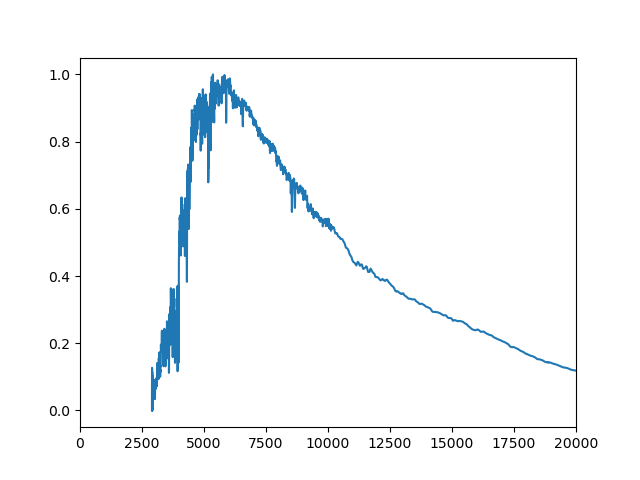

/Users/rridden/Documents/work/data/current_calspec/hd209458_stisnic_008.dat 16


<IPython.core.display.Javascript object>


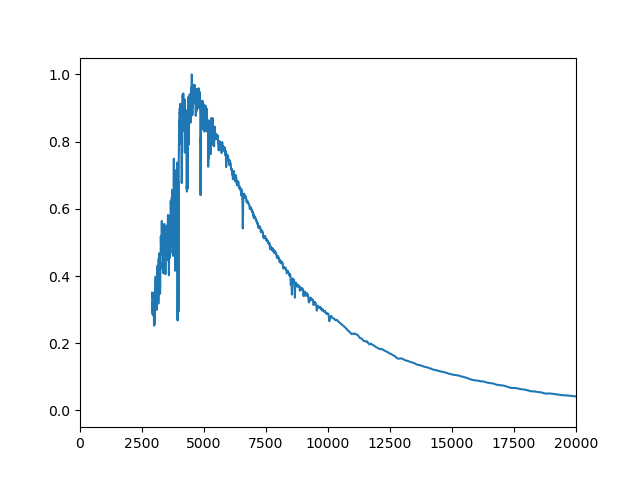

/Users/rridden/Documents/work/data/current_calspec/p177d_stisnic_008.dat 17


<IPython.core.display.Javascript object>


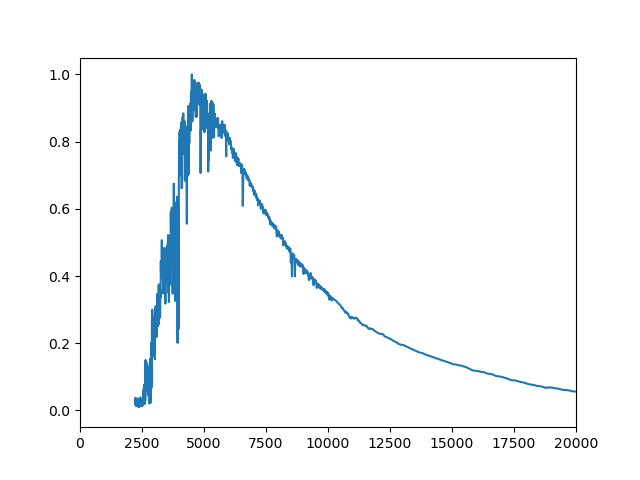

/Users/rridden/Documents/work/data/current_calspec/hd200654_stis_005.dat 18


<IPython.core.display.Javascript object>


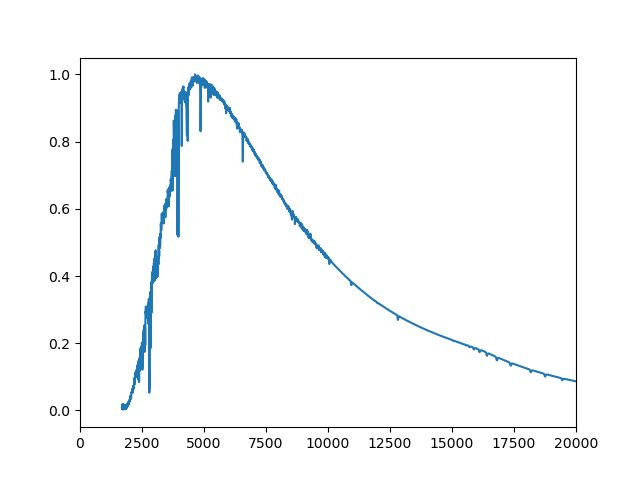

/Users/rridden/Documents/work/data/current_calspec/hd160617_stis_005.dat 19


<IPython.core.display.Javascript object>


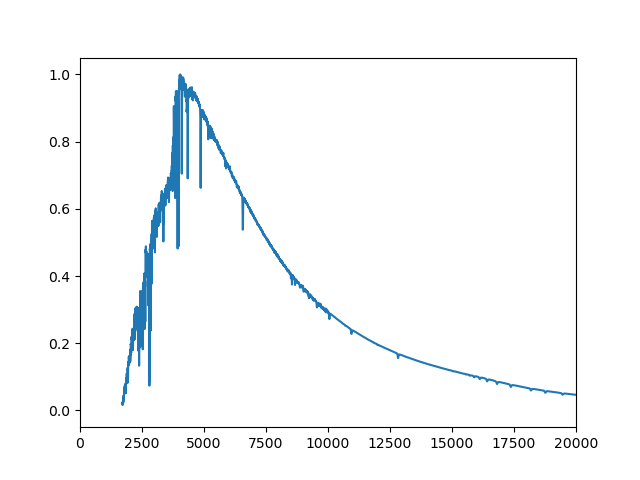

/Users/rridden/Documents/work/data/current_calspec/hd167060_stis_002.dat 20


<IPython.core.display.Javascript object>


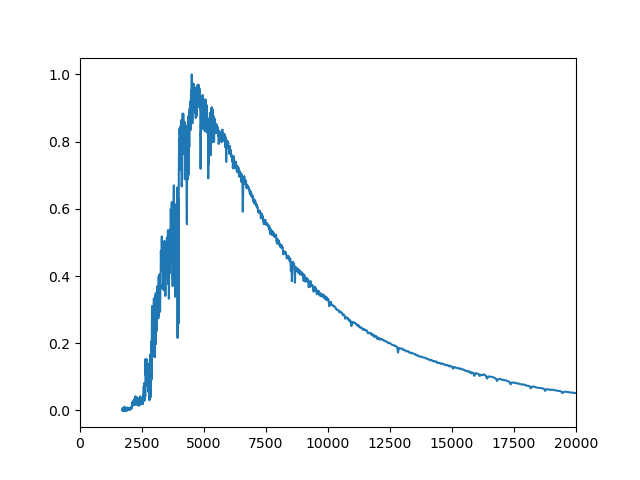

/Users/rridden/Documents/work/data/current_calspec/bd26d2606_stis_005.dat 21


<IPython.core.display.Javascript object>


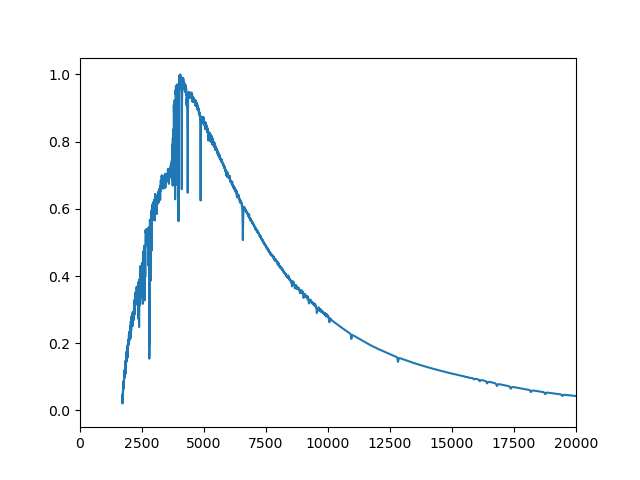

/Users/rridden/Documents/work/data/current_calspec/hd074000_stis_005.dat 22


<IPython.core.display.Javascript object>


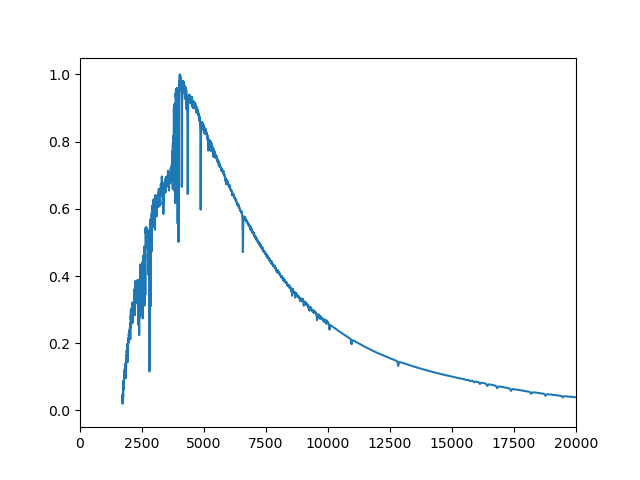

/Users/rridden/Documents/work/data/current_calspec/sun_reference_stis_002.dat 23


<IPython.core.display.Javascript object>


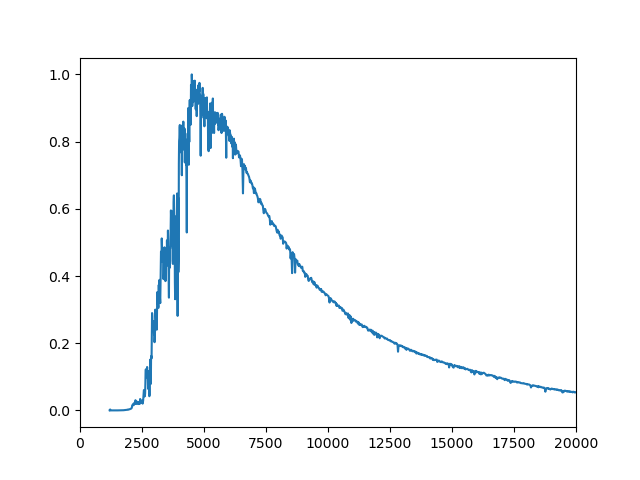

/Users/rridden/Documents/work/data/current_calspec/bd02d3375_stis_005.dat 24


<IPython.core.display.Javascript object>


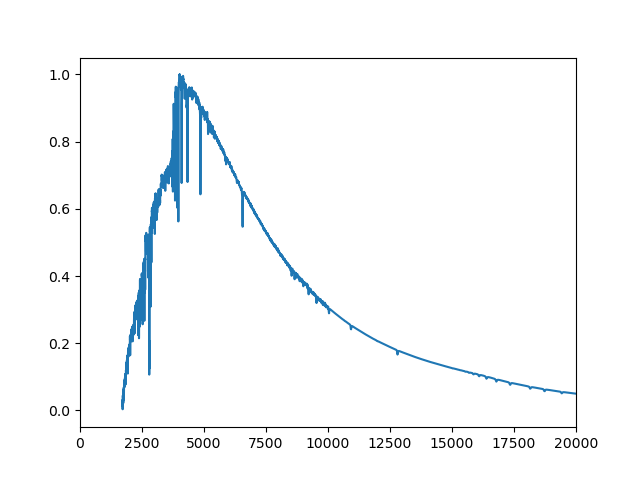

/Users/rridden/Documents/work/data/current_calspec/sf1615_001a_stisnic_008.dat 25


<IPython.core.display.Javascript object>


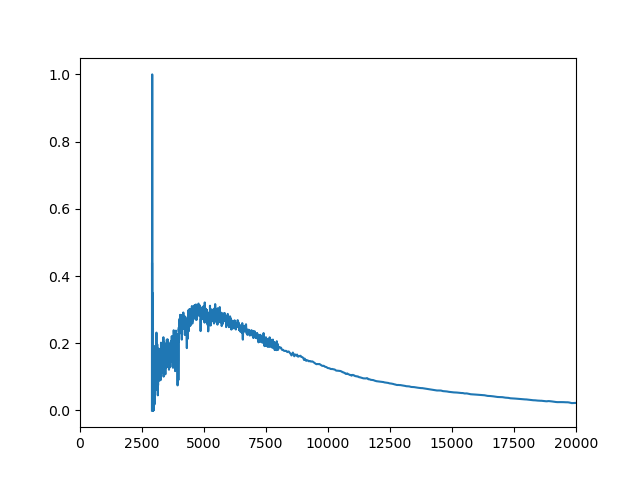

/Users/rridden/Documents/work/data/current_calspec/16cygb_stis_002.dat 26


<IPython.core.display.Javascript object>


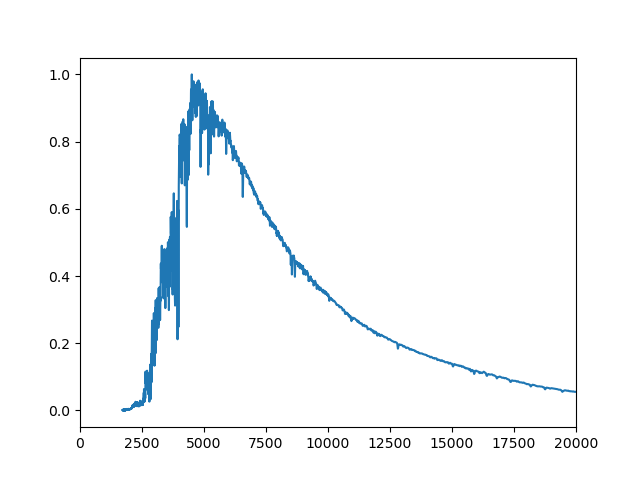

/Users/rridden/Documents/work/data/current_calspec/hd205905_stis_005.dat 27


<IPython.core.display.Javascript object>


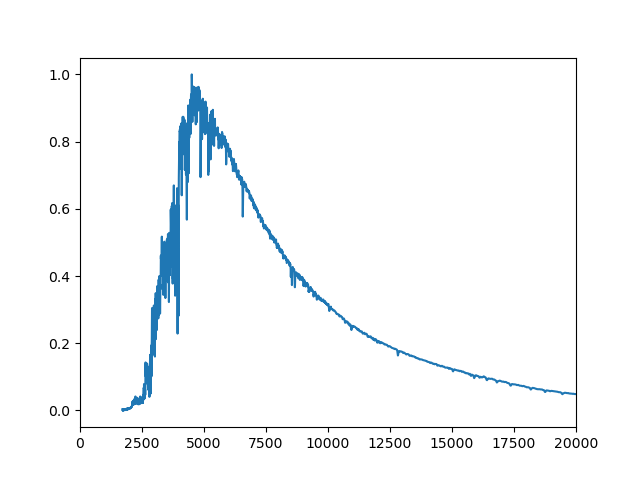

/Users/rridden/Documents/work/data/current_calspec/hd106252_stis_005.dat 28


<IPython.core.display.Javascript object>


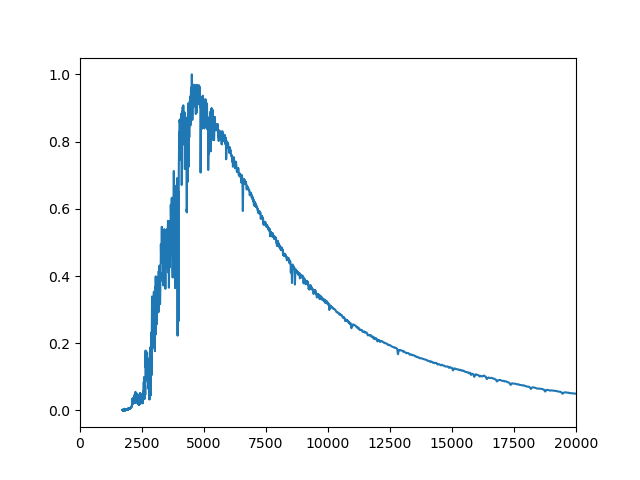

/Users/rridden/Documents/work/data/current_calspec/snap2_stiswfcnic_002.dat 29


<IPython.core.display.Javascript object>


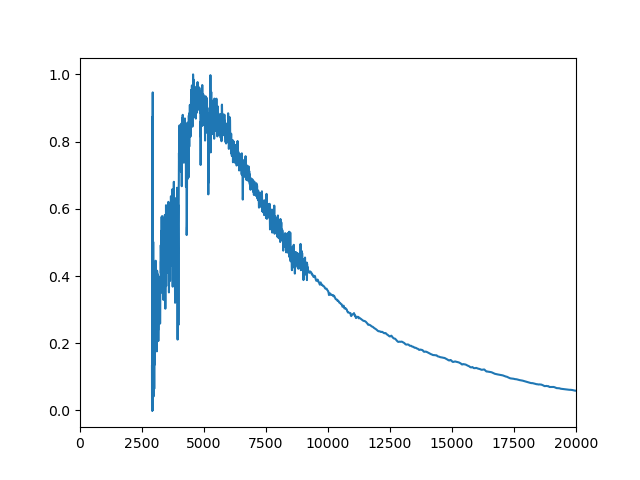

/Users/rridden/Documents/work/data/current_calspec/2m003618_stiswfcnic_003.dat 30


<IPython.core.display.Javascript object>


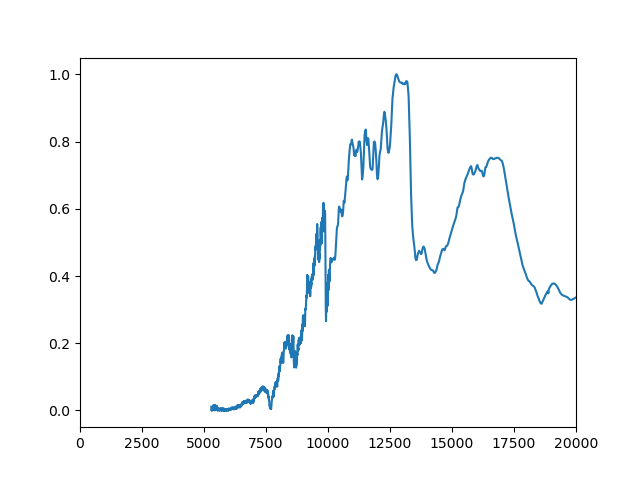

In [221]:
i = 0
for s in cur:
    print(current[good][i],i)
    i+=1
    plt.figure()
    
    plt.plot(s.wave,s.flux/np.nanmax(s.flux))
    plt.xlim(0,20000)

In [223]:
gr[22]

-0.05137191385452766

In [211]:
vals

array([ 0.00981329, -0.0012921 ])

<IPython.core.display.Javascript object>


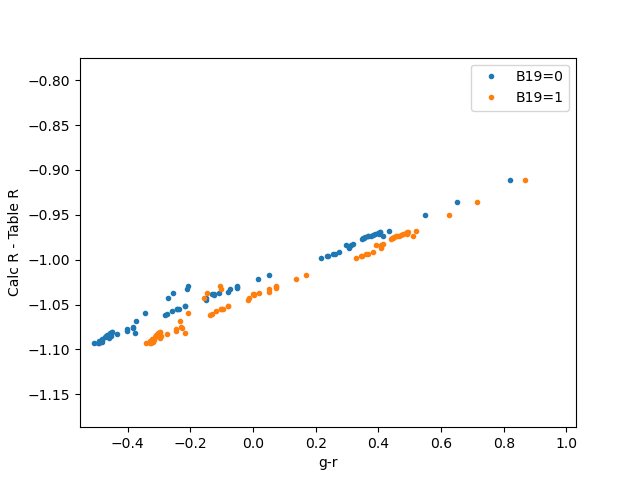

Text(0, 0.5, 'Calc R - Table R')

In [93]:
b='g'
plt.figure()
plt.plot(gr,(zero[b]-one[b])+2.617,'.',label='B19=0')
plt.plot(redgr-(3.518-2.617),(zero[b]-one[b])+2.617,'.',label='B19=1')
plt.legend()
plt.xlabel('g-r')
plt.ylabel('Calc R - Table R')

In [52]:
np.where((zero['g']-one['g'])+3.518 > .34)

(array([ 3, 79]),)

In [53]:
current[3]

'/Users/rridden/Documents/work/data/current_calspec/hz43b_stis_005.dat'

In [50]:
current[13]

'/Users/rridden/Documents/work/data/current_calspec/g191b2b_stisfuse_001.dat'

In [43]:
np.median(one['g'] - zero['g'])- 3.518

0.009653922798706027

In [44]:
np.argmin(abs(((one['g'] - zero['g'])/ 3.518) - 1))

32

In [45]:
(one['g'] - zero['g'])[32]/ 3.518

0.9991147597771736

In [46]:
current[32]

'/Users/rridden/Documents/work/data/current_calspec/1757132_stiswfc_002.dat'

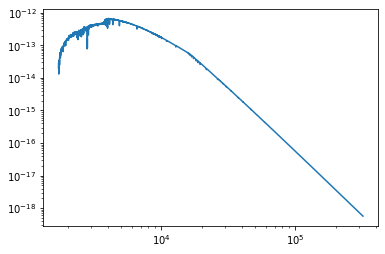

In [263]:
plt.figure()
plt.loglog(cur[22].wave,cur[22].flux)

In [30]:
zero['g'][60] - zero['r'][60]

-0.3434527451542735

In [192]:
np.nanmedian(one['g'] - zero['g']) / 3.518

1.0269559165192417

In [259]:
np.nanmedian(one['r'] - zero['r']) / 2.617

0.9936175001095392

In [260]:
np.nanmedian(one['i'] - zero['i']) / 1.971

1.028348453539579

In [261]:
np.nanmedian(one['g'] - zero['g']) / 3.518

0.9867185712742849

In [185]:
np.nanmedian(one['r'] - zero['r']) / 2.617

0.993155110991432

In [186]:
np.nanmedian(one['i'] - zero['i']) / 1.971

1.0248081310008823

In [45]:
magdiff*.981

array([0.10603179, 0.10583231, 0.10397295, 0.10469929, 0.1003004 ,
       0.10138652, 0.10046709, 0.10090846, 0.10423698, 0.10282318,
       0.10483546, 0.10578604, 0.09861567, 0.10446248, 0.10211133,
       0.10485971, 0.1034606 , 0.10565007, 0.10392707, 0.10310021,
       0.10494706, 0.10277617, 0.10589358, 0.10573901, 0.10623563,
       0.09980607, 0.100491  , 0.10597524, 0.10298396, 0.10062261,
       0.10214159, 0.1055873 , 0.10113226, 0.09946483, 0.10332887,
       0.10349599, 0.10512354, 0.10472694, 0.10211429, 0.10040288,
       0.10319204, 0.10273285, 0.1018698 , 0.1030297 , 0.1001141 ,
       0.10581129, 0.1027686 , 0.10027069, 0.10129071, 0.1005644 ,
       0.10376213, 0.10652112, 0.1059904 , 0.10534639, 0.1052937 ,
       0.1052107 , 0.10076192, 0.10585735, 0.10480062, 0.10580563,
       0.10056777, 0.10257403, 0.10328767, 0.10531873, 0.10048714,
       0.10042803, 0.10242543, 0.10583588, 0.10008578, 0.10376411,
       0.10543359, 0.10228183, 0.10340099, 0.09973927, 0.10052

In [46]:
test = fitzpatrick99(pickle['../stellar_spec/pickle/ukk2iii.dat'].wave, 1.0, 3.1)

In [48]:
%matplotlib notebook

<IPython.core.display.Javascript object>


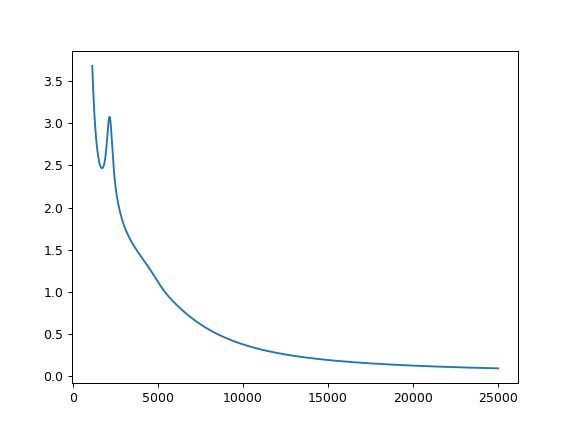

In [49]:
wave = pickle['../stellar_spec/pickle/ukk2iii.dat'].wave
plt.figure()
plt.plot(wave,test)

In [50]:
np.argmin(abs(wave - 5982.3))

966

In [52]:
test[966]*3.1

2.700204321952776

In [50]:
0.87/(3.1*0.981)

0.28608069448554796

In [55]:
from astropy.coordinates import SkyCoord
import astropy.units as u

In [57]:
SkyCoord('16:58:51.1126140106', '+34:18:53.321180387',unit=(u.hourangle, u.deg))

<SkyCoord (ICRS): (ra, dec) in deg
    (254.71296923, 34.31481144)>